This script is used to perform lesion segmentation in fundus photographs. The lesions that can be segmented are hard exudates, soft exudates, microaneurysms and hemorrhages. The segmentation is based on a UNet, a CNN that takes an image as an input and that outputs a probability map indicating for every pixel the probability of belonging to a certain type of lesion or not.

In [ ]:
!pip install tensorlayer==1.11.1
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# import necessary libraries

import numpy as np
import tensorflow as tf
import tensorlayer as tl
import tensorlayer.layers as tll
import tensorflow.keras.backend as K

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import time

print(tf.__version__)
print(tl.__version__)



1.15.2
1.11.1


In [ ]:
# read in train and test data in case Google DRIVE is used
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# read in the train and test data for a certain lesion type

# Basepath depends on the lesion
# LesionType = 'SoftExudates'
LesionType = 'HardExudates'
# LesionType = 'Microaneurysms'
# LesionType = 'Hemorrhages'

In [ ]:
# Basepath for Google DRIVE:
# Basepath = '/content/drive/My Drive/Stage_ENT_Studios/Data/IDRiD/' + LesionType + '/Arrays/'

# Basepath for Jupyter notebooks:
Basepath = 'C:/Users/lunam/Documents/1steMaster/Stage/Data_FinalArrays/IDRiD/'+ LesionType+'/Arrays/'

# train data
train_images = np.float32(np.load(Basepath + 'train_images_Final.npy'))
print('Shape train images: {}'.format(train_images.shape))

train_annotations =  np.int32(np.load(Basepath + 'train_annotations_Final.npy'))
# train_annotations = np.expand_dims(train_annotations, axis = 3)
print('Shape train annotations: {}'.format(train_annotations.shape))

# test data
test_images = np.float32(np.load(Basepath + 'test_images_Final.npy'))
print('Shape test images: {}'.format(test_images.shape))

test_annotations = np.int32(np.load(Basepath + 'test_annotations_Final.npy'))
# test_annotations = np.expand_dims(test_annotations, axis = 3)
print('Shape test annotations: {}'.format(test_annotations.shape))

Shape train images: (324, 512, 512, 3)
Shape train annotations: (324, 512, 512)
Shape test images: (156, 512, 512, 3)
Shape test annotations: (156, 512, 512)


In [ ]:
# directions where the tensorboard logs and the model are stored

# basepath for Google DRIVE
# base_path = '/content/drive/My Drive/Stage_ENT_Studios/Unet/Logs/'
# basepath for Jupyter notebooks
base_path = 'C:/Users/lunam/Documents/1steMaster/Stage/Code_Final/DR_classification/FeatureBasedClassification/UNet_Sigmoid/Logs/'+LesionType+'/'

# direction where the tensorboard files will be stored
log_dir_tens = base_path + 'Tensorboard_Logs/'
# direction where the trained models will be stored
log_dir_model = base_path + 'Trained_Model/'

# Load the tensorboard extension. Tensorboard will be used to visualize the training and testing of the network
%load_ext tensorboard

In [ ]:
# The UNet network
def UNet(image, drop_prob = 0.1, init_filters = 64, is_train = True):
    '''This function defines the original UNet network'''
    
    # initialization of the weights
    W_init = tf.contrib.layers.xavier_initializer()
        
    # Unet network
                
    # LEFT part
    # input layer
    input_image = tl.layers.InputLayer(image)
            
    # Convolutional block 1
    conv2d_1 = tl.layers.Conv2d(input_image, init_filters, (3, 3), act= tf.nn.relu, W_init= W_init)
    conv2d_2 = tl.layers.Conv2d(conv2d_1, init_filters, (3, 3), act= tf.nn.relu, W_init= W_init)
    pool_1 = tl.layers.MaxPool2d(conv2d_2, (2, 2), (2, 2), name= 'maxpool_1')
    dropout_1 = tl.layers.DropoutLayer(pool_1, keep= 1-drop_prob, is_fix = True, is_train=is_train)
                
    # Convolutional block 2
    conv2d_3 = tl.layers.Conv2d(dropout_1, 2*init_filters, (3,3), act= tf.nn.relu, W_init= W_init)
    conv2d_4 = tl.layers.Conv2d(conv2d_3, 2*init_filters, (3,3), act= tf.nn.relu, W_init= W_init)
    pool_2 = tl.layers.MaxPool2d(conv2d_4, (2,2), (2, 2), name='maxpool_2')
    dropout_2 = tl.layers.DropoutLayer(pool_2, keep= 1-drop_prob, is_fix = True, is_train=is_train)
                
    # Convolutional block 3
    conv2d_5 = tl.layers.Conv2d(dropout_2, 4*init_filters, (3,3), act= tf.nn.relu, W_init=W_init)
    conv2d_6 = tl.layers.Conv2d(conv2d_5, 4*init_filters, (3,3), act= tf.nn.relu, W_init=W_init)
    pool_3 = tl.layers.MaxPool2d(conv2d_6, (2,2), (2, 2), name='maxpool_3')
    dropout_3 = tl.layers.DropoutLayer(pool_3, keep= 1-drop_prob, is_fix = True, is_train=is_train)
                
    # Convolutional block 4
    conv2d_7 = tl.layers.Conv2d(dropout_3, 8*init_filters, (3,3), act= tf.nn.relu, W_init=W_init)
    conv2d_8 = tl.layers.Conv2d(conv2d_7, 8*init_filters, (3,3), act= tf.nn.relu, W_init=W_init)
    pool_4 = tl.layers.MaxPool2d(conv2d_8, (2,2), (2, 2), name='maxpool_4')
    dropout_4 = tl.layers.DropoutLayer(pool_4, keep= 1-drop_prob, is_fix = True, is_train=is_train)
                
    # MIDDLE part
    conv2d_9 = tl.layers.Conv2d(dropout_4, 16*init_filters, (3,3), act= tf.nn.relu, W_init=W_init)
    conv2d_10 = tl.layers.Conv2d(conv2d_9, 16*init_filters, (3,3), act= tf.nn.relu, W_init=W_init)
                
                
    # RIGHT part
    # Convolutional block 1
    upsampling_1 = tl.layers.UpSampling2dLayer(conv2d_10, (2,2))
    concat_1 = tl.layers.ConcatLayer([upsampling_1, conv2d_8], 3)
    dropout_5 = tl.layers.DropoutLayer(concat_1, keep= 1-drop_prob, is_fix = True, is_train=is_train)
    conv2d_11 = tl.layers.Conv2d(dropout_5, 8*init_filters, (3,3), act= tf.nn.relu, W_init=W_init)
    conv2d_12 = tl.layers.Conv2d(conv2d_11, 8*init_filters, (3,3), act= tf.nn.relu, W_init=W_init)
                
    # Convolutional block 2
    upsampling_2 = tl.layers.UpSampling2dLayer(conv2d_12, (2,2))
    concat_2 = tl.layers.ConcatLayer([upsampling_2, conv2d_6], 3)
    dropout_6 = tl.layers.DropoutLayer(concat_2, keep= 1-drop_prob, is_fix = True, is_train=is_train)
    conv2d_13 = tl.layers.Conv2d(dropout_6, 4*init_filters, (3,3), act= tf.nn.relu, W_init=W_init)
    conv2d_14 = tl.layers.Conv2d(conv2d_13, 4*init_filters, (3,3), act= tf.nn.relu, W_init=W_init)
            
                
    # Convolutional block 3
    upsampling_3 = tl.layers.UpSampling2dLayer(conv2d_14, (2,2))
    concat_3 = tl.layers.ConcatLayer([upsampling_3,conv2d_4], 3)
    dropout_7 = tl.layers.DropoutLayer(concat_3, keep= 1-drop_prob, is_fix = True, is_train=is_train)
    conv2d_15 = tl.layers.Conv2d(dropout_7, 2*init_filters, (3,3), act= tf.nn.relu, W_init= W_init)
    conv2d_16 = tl.layers.Conv2d(conv2d_15, 2*init_filters, (3,3), act= tf.nn.relu, W_init= W_init)
                
    # Convolutional block 4
    upsampling_4 = tl.layers.UpSampling2dLayer(conv2d_16, (2,2))
    concat_4 = tl.layers.ConcatLayer([upsampling_4,conv2d_2], 3)
    dropout_8 = tl.layers.DropoutLayer(concat_4, keep= 1-drop_prob, is_fix = True, is_train=is_train)
    conv2d_17 = tl.layers.Conv2d(dropout_8, init_filters, (3,3), act= tf.nn.relu, W_init= W_init)
    conv2d_18 = tl.layers.Conv2d(conv2d_17, init_filters, (3,3), act= tf.nn.relu, W_init= W_init)
                
                
    # ouput layer
    output_image = tl.layers.Conv2d(conv2d_18, 1, (1,1), W_init= W_init) 

    # logits tensor, often a step inbetween befor a softmax activation is applied (size im_size x im_size, 2)
    logits = output_image.outputs

    # the model
    model = output_image

    # a binary output map with size im_size x im_size can be found by applying the argmax operation
    # this operation yields 0 or 1 for every pixel position depending on whether the value in the first or second image is the largest
    binary_prediction = tf.math.argmax(logits, axis= 3, name= 'prediction')
        
    return binary_prediction, logits, output_image

Visualize the training process with tensorboard

In [ ]:
# visualize the training results with tensorboard
# %tensorboard --logdir {log_dir_tens}  --host localhost

In [ ]:
def Reload_and_Predict(TestImages, TestAnnotations, Drop_Prob = 0.1, Init_Filters = 64, log_dir_trained_model = log_dir_model, test_batch = 6, epochs = 10):
    '''This function reloads a trained model and predicts the annotations of images'''
    TestAnnotations = np.expand_dims(TestAnnotations, axis = 3)
    TestAnnotations = np.where(TestAnnotations> 0, 1, 0)
    
    # placeholders are created, variables to which data is assigned later on
    print('Create placeholders')
    image = tf.placeholder(tf.float32, [None,512,512, 3], name= 'image')
    annotation = tf.placeholder(tf.int32, shape=[None, 512, 512, 1], name= "annotation")

    # Define the model for testing
    print('Define the model for testing')
    test_pred, test_logits, test_network = UNet(image, drop_prob = Drop_Prob, init_filters = Init_Filters, is_train = False)
        
    # softmax activation of the output to end up with probability maps
    print('Define the probability outputs')
    test_positive_prob = tf.nn.sigmoid(test_logits)
        
    # start up a session in which the pretrained model is reloaded
    sess = tf.Session()    
    tl.layers.initialize_global_variables(sess)
    sess.run(tf.global_variables_initializer())
    
    print('Restoring model...')
    new_saver = tf.train.import_meta_graph(log_dir_trained_model + 'model.ckpt-'+ str(epochs) +'.meta')
    ckpt = tf.train.get_checkpoint_state(log_dir_trained_model)
    new_saver.restore(sess, ckpt.model_checkpoint_path)
    print('Model restored...')
        
    # predict the annotations for the test images
    print('Predicting the test cases...')

    # the test samples have to go through in batches as otherwise the memmory crashes
    # number of batches
    predicted_prob_maps = []
    n_batches = int(TestImages.shape[0] / test_batch)
    if TestImages.shape[0] % test_batch != 0:
        print('Amount of test images is not dividable by the chosen test batch size!')
        print('Number of images: {}'.format(TestImages.shape[0]))
        print('Chosen batch size: {}'.format( test_batch))

    for i in range(n_batches):
        start = i*test_batch
        end = start + test_batch
        feed_dict= {image: TestImages[start:end]}
        test_pos_prob= sess.run([test_positive_prob], feed_dict= feed_dict)
        test_pos_prob = np.array(test_pos_prob)
        
        if i == 0:
            predicted_prob_maps = test_pos_prob[0,:,:,:,0]
        else:
            predicted_prob_maps = np.vstack((predicted_prob_maps, test_pos_prob[0,:,:,:,0]))

    print('Test data predicted')
    
    # test_positive_prob gives the output probability map that can be used as an input to the test function
    return predicted_prob_maps

In [ ]:
predicted_annot = Reload_and_Predict(test_images, test_annotations, Drop_Prob = 0.1, Init_Filters = 64, log_dir_trained_model = log_dir_model, test_batch= 6, epochs= 20)
# epochs are needed to define the name of the file to restore the model
# test batch has to be defined as a number through which the total amount of test images if dividable

Create placeholders
Define the model for testing
[TL] InputLayer  input: (?, 512, 512, 3)
[TL] Conv2d conv2d: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: relu
[TL] Conv2d conv2d: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: relu
[TL] MaxPool2d maxpool_1: filter_size: (2, 2) strides: (2, 2) padding: SAME
[TL] DropoutLayer dropout_layer: keep: 0.900000 is_fix: True
[TL]   skip DropoutLayer
[TL] Conv2d conv2d: n_filter: 128 filter_size: (3, 3) strides: (1, 1) pad: SAME act: relu
[TL] Conv2d conv2d: n_filter: 128 filter_size: (3, 3) strides: (1, 1) pad: SAME act: relu
[TL] MaxPool2d maxpool_2: filter_size: (2, 2) strides: (2, 2) padding: SAME
[TL] DropoutLayer dropout_layer: keep: 0.900000 is_fix: True
[TL]   skip DropoutLayer
[TL] Conv2d conv2d: n_filter: 256 filter_size: (3, 3) strides: (1, 1) pad: SAME act: relu
[TL] Conv2d conv2d: n_filter: 256 filter_size: (3, 3) strides: (1, 1) pad: SAME act: relu
[TL] MaxPool2d maxpool_3: filter_size: (2, 2) st

Beneith some functions are indicated that can be used to evaluate the trained model. They are all brought together in the Evaluate funtion.

In [ ]:
def ROC(pred_probs, true_probs, plot = True):
    '''
    This function calculates the ROC-AUC value
    and it also calculates and visualizes the ROC-curve (if plot is true)
    '''
    
    # calculate and print out ROC-AUC value
    ROC_AUC = roc_auc_score(true_probs, pred_probs)
    
    # calculate and plot the ROC-curve
    if plot:
        FPRate, TPRate, Thresh = roc_curve(true_probs, pred_probs)
        plt.figure()
        plt.plot(FPRate, TPRate)
        plt.title('ROC curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

    return ROC_AUC

In [ ]:
def PRC(pred_probs, true_probs, plot = True):
    '''
    Calculate the aupr value = the area under the precision-recall curve
    and plot the precision-recall curve (if plot is true)
    '''
    
    # calculate the precision-recall curve
    Precision, Recall, Thresh = precision_recall_curve(true_probs, pred_probs)
    Precision = np.fliplr([Precision])[0]  # so the array is increasing (you won't get negative AUC)
    Recall = np.fliplr([Recall])[0]  # so the array is increasing (you won't get negative AUC)
    AUPR = np.trapz(Precision, Recall)
      
    
    # plot the precision-recall curve
    if plot:
        plt.figure()
        plt.plot(Precision, Recall)
        plt.title('Precision-Recall curve')
        plt.xlabel('Precision')
        plt.ylabel('Recall')
        plt.show()
    
    return AUPR

In [ ]:
def ConfusionMatrix(pred_probs, true_probs, threshold_confusion = 0.5):
    '''
    Calculate and print out the confusion matrix
    The values for the confusion matrix are also returned
    A standard threhsold of 0.5 is used to calculate the confusion matrix
    '''
    # print out the threshold that is used for the confusion matrix
    print("Confusion matrix with a used threshold of {} for the positive class:".format(threshold_confusion))
    
    # turn the predicted probability maps into binary outputs according to the threshold
    # binary annotation

    thresh_pred_probs = np.empty((pred_probs.shape[0]))
    for i in range(pred_probs.shape[0]):
        if pred_probs[i] >= threshold_confusion:
            thresh_pred_probs[i] = 1
        else:
            thresh_pred_probs[i] = 0
    
    # calculate the confusion-matrix and print it out
    TN, FP, FN, TP = confusion_matrix(true_probs, thresh_pred_probs).ravel()
    print('Amount of true positives: {}'.format(TP))
    print('Amount of false positives: {}'.format(FP))
    print('Amount of true negatives: {}'.format(TN))
    print('Amount of false negatives: {}'.format(FN))
    
    return TN, FP, FN, TP

In [ ]:
def Metrics(tn, fp, fn, tp):
    '''Print out some metrics like the accuracy, specificity, sensitivity and precision'''
    
    print('Some metrics:')
    
    # print out accuracy
    accuracy = 0
    if (tn+fp+fn+tp) != 0:
        accuracy = (tp+tn)/(tn+fp+fn+tp)
    print('Accuracy: {}'.format(accuracy))
    
    # print out specificity
    specificity = 0
    if (tn+fp) != 0:
        specificity = tn/(tn+fp)
    print('Specificity: {}'.format(specificity))
    
    # print out sensitivity
    sensitivity = 0
    if (tp+fn) != 0:
        sensitivity = tp/(tp+fn)
    print('Sensitivity: {}'.format(sensitivity))
    
    # print out precision
    precision = 0
    if (tp+fp) != 0:
        precision = tp/(tp+fp)
    print('Precision: {}'.format(precision))


In [ ]:
# evaluation of the model
def Evaluate(pred_prob_maps, true_prob_maps):
    '''
    Evaluation of the network, based on comparisson between the true and predicted outputs
    '''
    print('Evaluating the model...')
    
    # creat a 1D numpy array with the predicted and true outputs
    pred_prob_maps = pred_prob_maps.reshape(-1)
    true_prob_maps = true_prob_maps.reshape(-1)

    # print out ROC-AUC value and plot the ROC-curve
    ROC_AUC = ROC(pred_prob_maps, true_prob_maps)
    print('Area under the ROC curve: {}'.format(ROC_AUC))

    # print out area under the precision-recall curve, AUPR value
    AUPR = PRC(pred_prob_maps, true_prob_maps)
    print('Area under Precision-Recall curve: {}'.format(AUPR))
    
    # print out confusion matrix
    TN, FP, FN, TP = ConfusionMatrix(pred_prob_maps, true_prob_maps)
    
    # print out some metrics
    Metrics(TN, FP, FN, TP)

Evaluating the model...


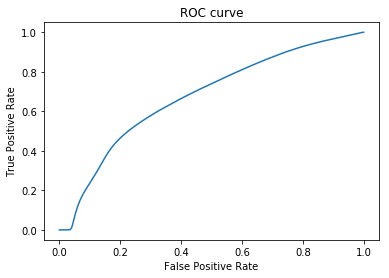

Area under the ROC curve: 0.6749836475818388


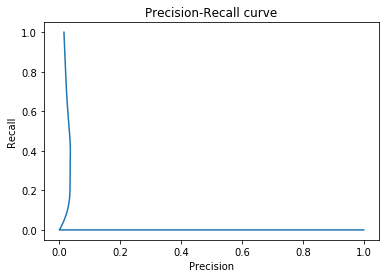

Area under Precision-Recall curve: 0.02692973508205889
Confusion matrix with a used threshold of 0.5 for the positive class:
Amount of true positives: 510368
Amount of false positives: 24561766
Amount of true negatives: 15708104
Amount of false negatives: 114226
Some metrics:
Accuracy: 0.39659333840394634
Specificity: 0.3900708892281003
Sensitivity: 0.8171196008927399
Precision: 0.02035598565323558


In [ ]:
Evaluate(predicted_annot, test_annotations)

In [ ]:
# to visualize some predictions
def PlotImage(image_array, database = '', image_name = '', save = False, savepath = ''):
    '''Visualize (and save if desired) an image represented by a numpy array'''
    
    plt.figure()
    plt.title(database+': '+image_name)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.imshow(image_array, cmap=plt.cm.Greys_r)
    
    if save == True:
        plt.savefig(savepath+database+'_'+image_name+'.png')
    
    return 

(156, 512, 512)


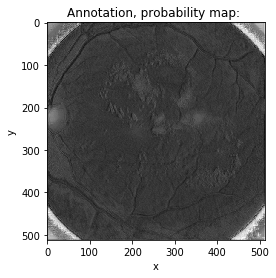

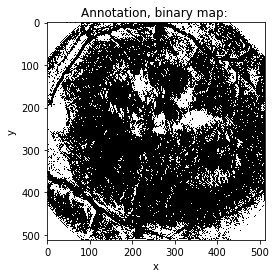

In [ ]:
# visualize the predicted probability map annotation and the predicted binary annotation
# probability map annotation
prob_annotation = predicted_annot[0]
PlotImage(prob_annotation, database = 'Annotation, probability map')


# binary annotation
positives = np.where(prob_annotation > 0.5)
bin_annotation = np.zeros(prob_annotation.shape)
bin_annotation[positives] = 1

PlotImage(bin_annotation, database = 'Annotation, binary map')

To kill an active tensorboard session:
Go to the anaconda prompt and type:

taskkill /im tensorboard.exe /f

del /q %TMP%\.tensorboard-info\*


or in the windows command prompt:

taskkill /IM "tensorboard.exe" /F